In [ ]:
!pip install pmdarima

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima.model import ARIMA
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

data = pd.read_csv('RSAFS.csv')

data['DATE'] = pd.to_datetime(data['DATE'])
data.set_index('DATE', inplace=True)

result = adfuller(data['RSAFS'])
print(f"p-value: {result[1]}")



p-value: 0.9971061031620092


               RSAFS          trend      season        resid  month  quarter  \
DATE                                                                           
1992-01-01  164095.0  162768.784820  726.386553   599.828627      1        1   
1992-02-01  164213.0  163597.608202 -498.901803  1114.293601      2        1   
1992-03-01  163721.0  164434.425806 -958.312659   244.886853      3        1   
1992-04-01  164709.0  165278.518993 -208.018103  -361.500890      4        2   
1992-05-01  165612.0  166128.581886 -165.148407  -351.433478      5        2   

            dayofweek  
DATE                   
1992-01-01          2  
1992-02-01          5  
1992-03-01          6  
1992-04-01          2  
1992-05-01          4  


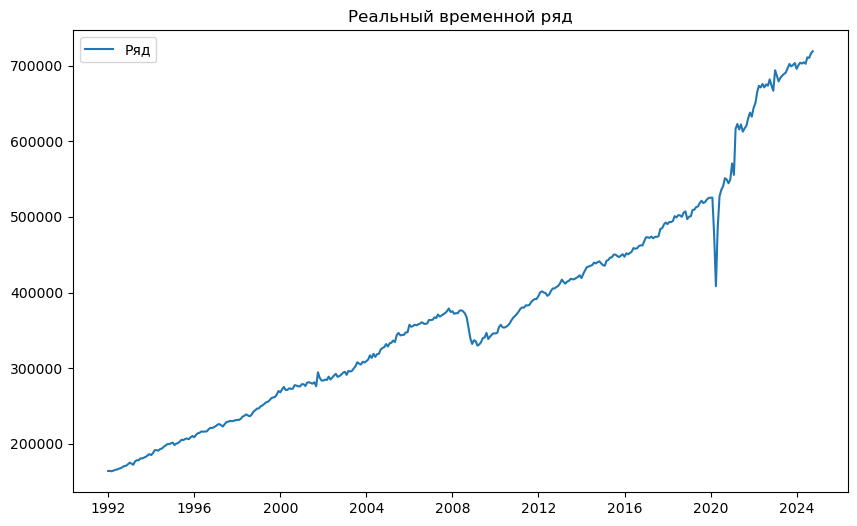

In [22]:
print(data.head())

plt.figure(figsize=(10, 6))
plt.plot(data.index, data['RSAFS'], label='Ряд')
plt.title('Реальный временной ряд')
plt.legend()
plt.show()

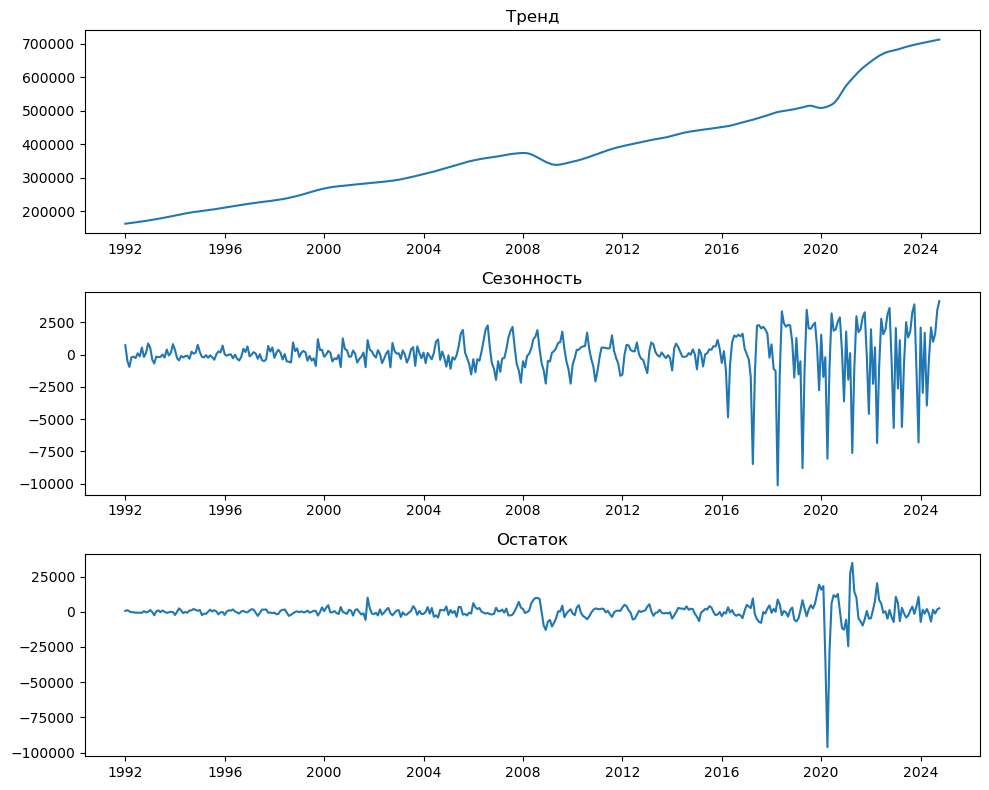

In [5]:
stl = STL(data['RSAFS'], seasonal=13)
result_stl = stl.fit()

trend = result_stl.trend
season = result_stl.seasonal
resid = result_stl.resid

plt.figure(figsize=(10, 8))
plt.subplot(3, 1, 1)
plt.plot(data.index, trend)
plt.title('Тренд')

plt.subplot(3, 1, 2)
plt.plot(data.index, season)
plt.title('Сезонность')

plt.subplot(3, 1, 3)
plt.plot(data.index, resid)
plt.title('Остаток')

plt.tight_layout()
plt.show()

In [9]:
data['trend'] = trend
data['season'] = season
data['resid'] = resid
data['month'] = data.index.month
data['quarter'] = data.index.quarter
data['dayofweek'] = data.index.dayofweek

train = data['RSAFS'][:-6]
test = data['RSAFS'][-6:]


best_arima = None
best_aic = float('inf')

for p in range(1, 4):
    for d in range(1, 2):
        for q in range(1, 4):
            try:
                arima_model = ARIMA(train, order=(p, d, q))
                arima_model_fit = arima_model.fit()
                if arima_model_fit.aic < best_aic:
                    best_aic = arima_model_fit.aic
                    best_arima = arima_model_fit
            except:
                continue

arima_forecast = best_arima.forecast(steps=6) # Прогноз на 6 месяцев для ARIMA

/Applications/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Applications/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Applications/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Applications/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Applications/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was p

Train:
DATE
2023-12-01    703256.0
2024-01-01    695631.0
2024-02-01    700519.0
2024-03-01    703738.0
2024-04-01    702681.0
Name: RSAFS, dtype: float64
Test:
DATE
2024-05-01    704309.0
2024-06-01    702350.0
2024-07-01    710851.0
2024-08-01    710038.0
2024-09-01    716026.0
Name: RSAFS, dtype: float64


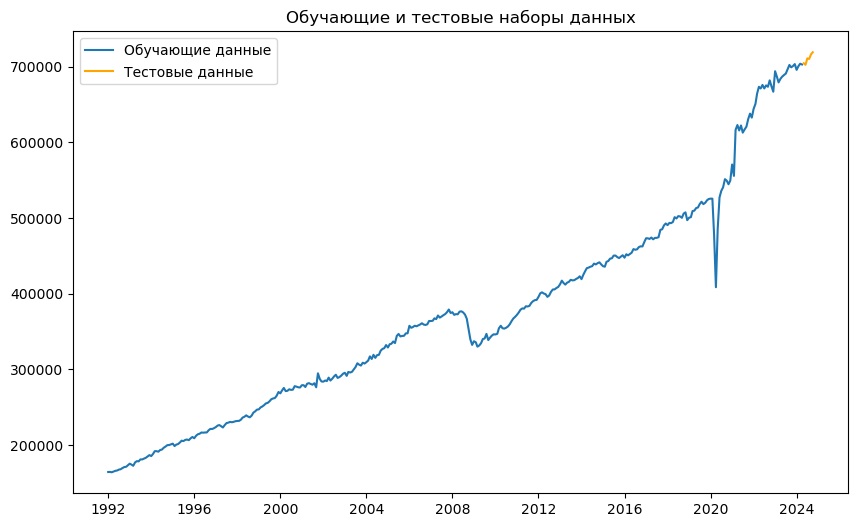

In [24]:
# Show training and test datasets
print('Train:')
print(train.tail())

print('Test:')
print(test.head())

# Plot train and test data
plt.figure(figsize=(10, 6))
plt.plot(train.index, train, label='Обучающие данные')
plt.plot(test.index, test, label='Тестовые данные', color='orange')
plt.title('Обучающие и тестовые наборы данных')
plt.legend()
plt.show()

In [13]:
# Прогнозирование с использованием Random Forest, для этого создаем лаги и дополнительные признаки
X_train = data[['trend', 'season', 'month', 'quarter', 'dayofweek']].iloc[:-6]
y_train = train
X_test = data[['trend', 'season', 'month', 'quarter', 'dayofweek']].iloc[-6:]
y_test = test

# Стандартизируем данные
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

rf_model = RandomForestRegressor() # Оптимизируем гиперпараметры
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5, 10]
}
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train)
rf_model_best = grid_search.best_estimator_

rf_forecast = rf_model_best.predict(X_test_scaled) # Прогнозируем с использованием лучшей модели

In [15]:
# Оценка модели
rmse_arima = sqrt(mean_squared_error(y_test, arima_forecast))
rmse_rf = sqrt(mean_squared_error(y_test, rf_forecast))

mae_arima = mean_absolute_error(y_test, arima_forecast)
mae_rf = mean_absolute_error(y_test, rf_forecast)

mape_arima = np.mean(np.abs((y_test - arima_forecast) / y_test)) * 100
mape_rf = np.mean(np.abs((y_test - rf_forecast) / y_test)) * 100

print(f"ARIMA - RMSE: {rmse_arima}, MAE: {mae_arima}, MAPE: {mape_arima}")
print(f"Random Forest - RMSE: {rmse_rf}, MAE: {mae_rf}, MAPE: {mape_rf}")

ARIMA - RMSE: 10722.263982061168, MAE: 8775.833856774281, MAPE: 1.2282688642787574
Random Forest - RMSE: 11631.423499650247, MAE: 9797.094972222229, MAPE: 1.3719241337662789


/var/folders/lm/1__jkxy526b22h77535ptych0000gn/T/ipykernel_18149/2795565527.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=6, freq='M')


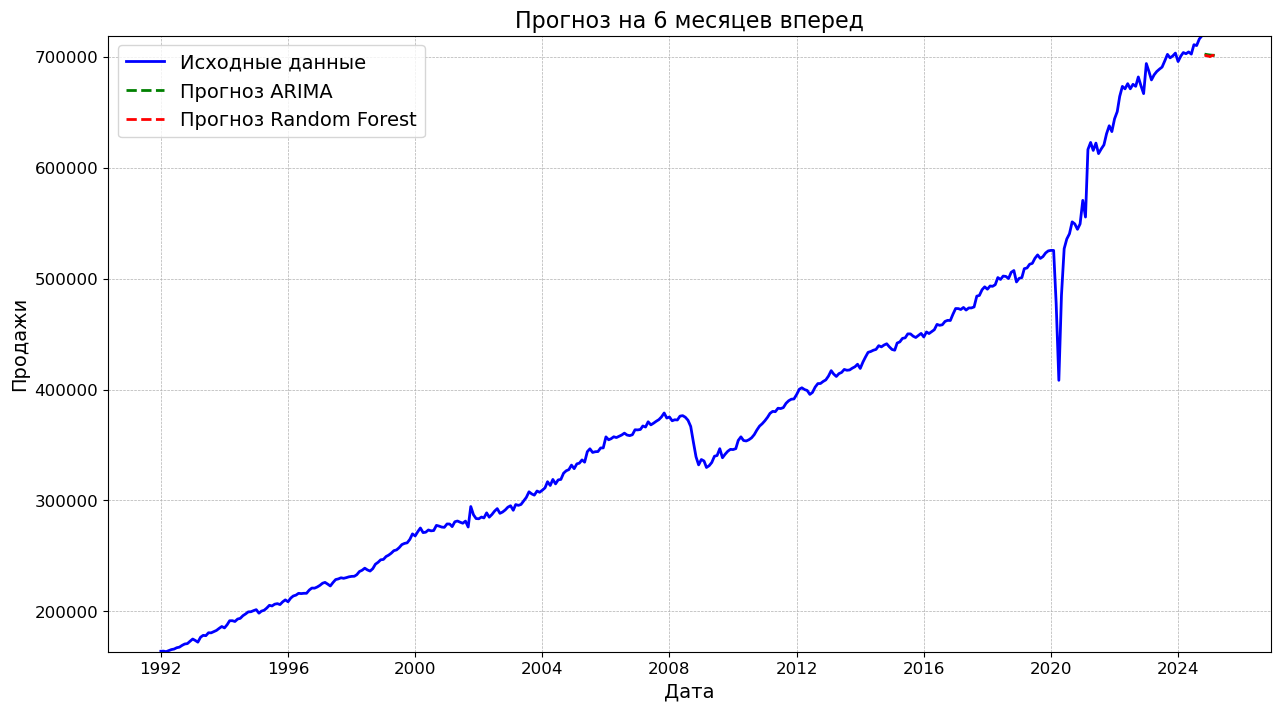

модель ARIMA показала лучшие результаты


In [17]:
# Прогноз на ближайшие 6 месяцев для ARIMA и Random Forest
future_dates = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=6, freq='M')

plt.figure(figsize=(15, 8))
plt.plot(data.index, data['RSAFS'], label='Исходные данные', color='b', linewidth=2)
plt.plot(future_dates, arima_forecast, label='Прогноз ARIMA', linestyle='--', color='g', linewidth=2)
plt.plot(future_dates, rf_forecast, label='Прогноз Random Forest', linestyle='--', color='r', linewidth=2)

y_min = min(data['RSAFS'].min(), arima_forecast.min(), rf_forecast.min()) - 50
y_max = max(data['RSAFS'].max(), arima_forecast.max(), rf_forecast.max()) + 50
plt.ylim(y_min, y_max)
plt.legend(fontsize=14)
plt.title('Прогноз на 6 месяцев вперед', fontsize=16)
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Продажи', fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

if mape_arima < mape_rf:
    print("модель ARIMA показала лучшие результаты")
else:
    print("модель Random Forest показала лучшие результаты")

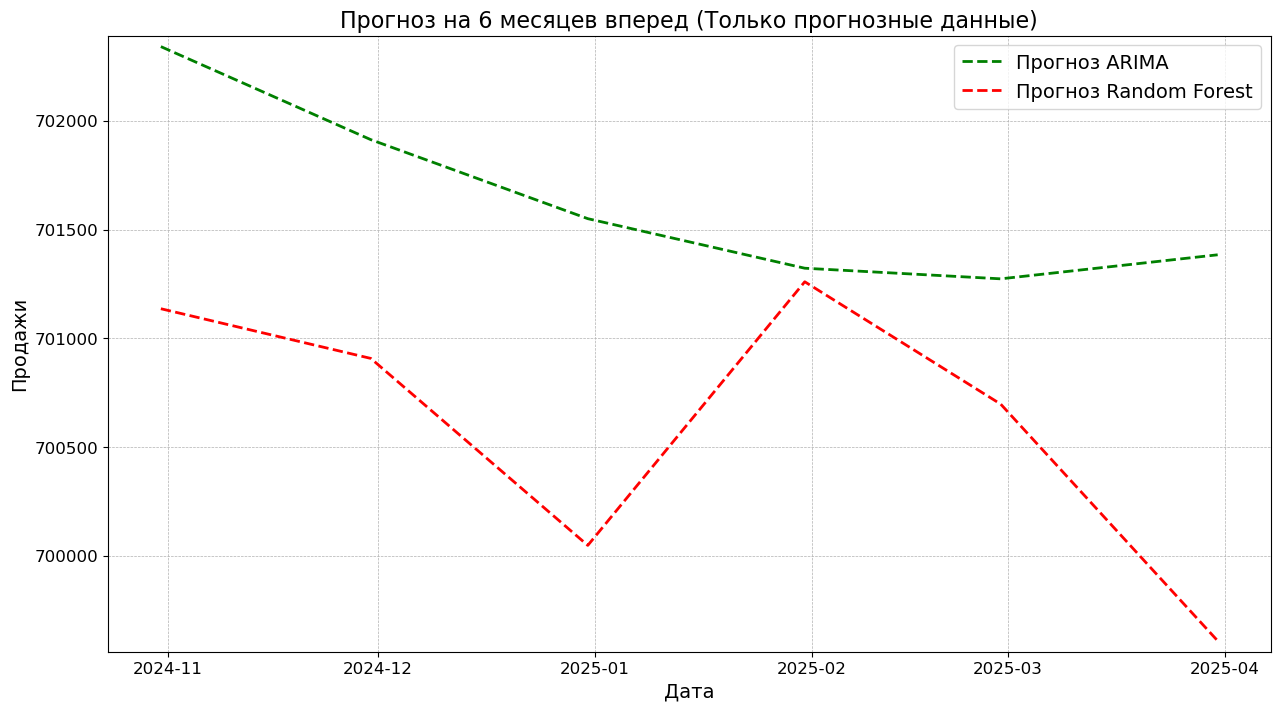

In [20]:
plt.figure(figsize=(15, 8))
plt.plot(future_dates, arima_forecast, label='Прогноз ARIMA', linestyle='--', color='g', linewidth=2)
plt.plot(future_dates, rf_forecast, label='Прогноз Random Forest', linestyle='--', color='r', linewidth=2)

y_min = min(arima_forecast.min(), rf_forecast.min()) - 50
y_max = max(arima_forecast.max(), rf_forecast.max()) + 50
plt.ylim(y_min, y_max)
plt.legend(fontsize=14)
plt.title('Прогноз на 6 месяцев вперед (Только прогнозные данные)', fontsize=16)
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Продажи', fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()